# Task 3: Heart Disease Prediction

### Step 1: Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve


### Step 2: Load the Dataset

In [3]:
# Load the dataset
df = pd.read_csv('heart_disease_uci.csv')  # Adjust path if needed
df.head()


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


### Step 3: Check for Missing Values

In [5]:
# Check for missing values
print(df.info())
print("\nMissing values:\n", df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB
None

Missing values:
 id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol      

### Step 4: Handling Missing Values

In [7]:
# Copy the dataframe to avoid modifying original (optional)
df_cleaned = df.copy()

# Drop 'id' and 'dataset' as they don't contribute to prediction
df_cleaned.drop(columns=['id', 'dataset'], inplace=True)

# Impute numerical columns with median
num_cols = ['trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
for col in num_cols:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

# Impute categorical columns with mode
cat_cols = ['fbs', 'restecg', 'exang', 'slope', 'thal']
for col in cat_cols:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

# Verify no missing values remain
print("Missing values after imputation:\n", df_cleaned.isnull().sum())


Missing values after imputation:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


C:\Users\PMLS\AppData\Local\Temp\ipykernel_31724\1749413169.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])


### Step 5: Correlation Heatmap

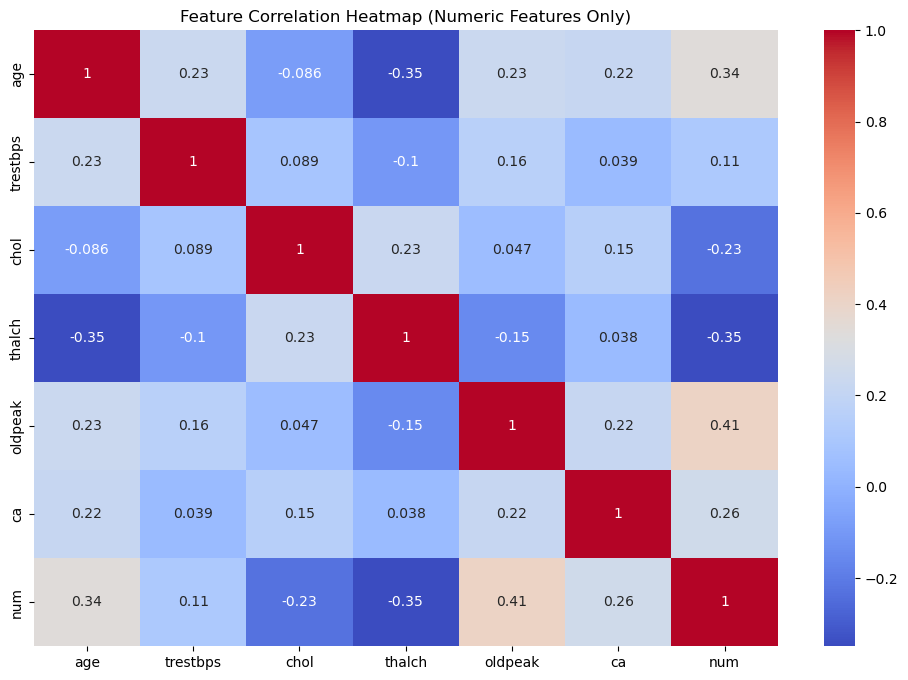

In [11]:
# Select only numeric columns for correlation
numeric_df = df_cleaned.select_dtypes(include=['float64', 'int64'])

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap (Numeric Features Only)')
plt.show()


### Step 6: Encode Categorical Variables

In [13]:
from sklearn.preprocessing import LabelEncoder

# Create a copy of the cleaned dataset
df_encoded = df_cleaned.copy()

# Identify categorical columns
cat_cols = df_encoded.select_dtypes(include='object').columns

# Apply label encoding
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

df_encoded.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,1,3,145.0,233.0,True,0,150.0,False,2.3,0,0.0,0,0
1,67,1,0,160.0,286.0,False,0,108.0,True,1.5,1,3.0,1,2
2,67,1,0,120.0,229.0,False,0,129.0,True,2.6,1,2.0,2,1
3,37,1,2,130.0,250.0,False,1,187.0,False,3.5,0,0.0,1,0
4,41,0,1,130.0,204.0,False,0,172.0,False,1.4,2,0.0,1,0


### Step 7: Exploratory Data Analysis (EDA)

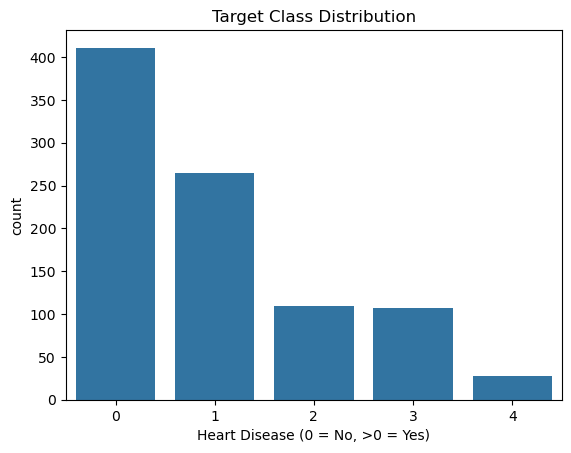

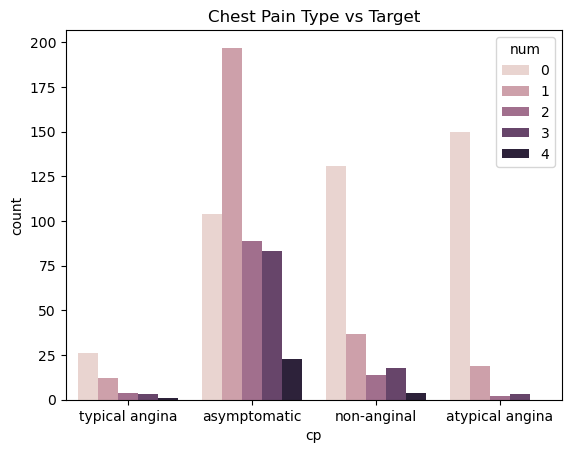

In [15]:
# Target variable distribution
sns.countplot(x='num', data=df_encoded)
plt.title('Target Class Distribution')
plt.xlabel('Heart Disease (0 = No, >0 = Yes)')
plt.show()

# Example: Chest pain type vs target
sns.countplot(x='cp', hue='num', data=df_cleaned)
plt.title('Chest Pain Type vs Target')
plt.show()


### Step 8: Feature Engineering and Data Splitting

In [17]:
# Define target and features
X = df_encoded.drop('num', axis=1)
y = (df_encoded['num'] > 0).astype(int)  # Convert target to binary (0 or 1)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Step 9: Train a Classification Model (Logistic Regression)

In [19]:
# Train logistic regression model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)


### Step 10: Evaluate the Model

Accuracy: 0.782608695652174
Confusion Matrix:
 [[62 13]
 [27 82]]


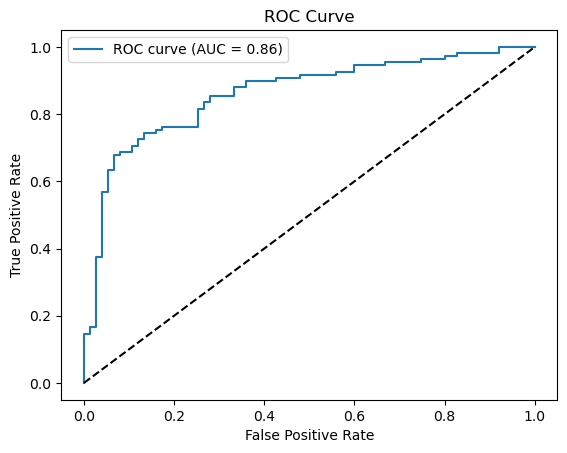

In [21]:
# Evaluate logistic regression model
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# ROC Curve
y_prob = lr.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


### Step 11: Feature Importance

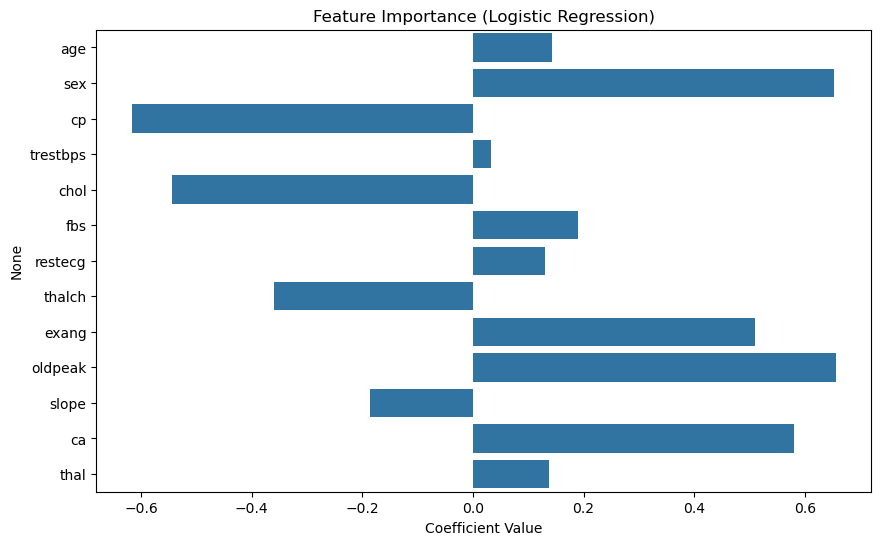

In [23]:
# Feature importance from logistic regression coefficients
importance = lr.coef_[0]
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importance, y=features)
plt.title('Feature Importance (Logistic Regression)')
plt.xlabel('Coefficient Value')
plt.show()
